In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Read Data

In [2]:
prices = pd.read_pickle('../get_data/prices_data.pkl')
len(prices['gvkey'].unique())

1198

In [3]:
lgbm_pred = pd.read_pickle('../results/lgbm_predictions.pkl')
lr_pred = pd.read_pickle('../results/lr_predictions.pkl')
len(lgbm_pred), len(lr_pred)

(31866, 31866)

In [4]:
lgbm_pred = lgbm_pred.rename(columns={'direction_pred':'lgbm_direction_pred',
                                      'value_pred':'lgbm_value_pred'})
lr_pred = lr_pred.rename(columns={'direction_pred':'lr_direction_pred',
                                  'value_pred':'lr_value_pred'})

In [5]:
general_columns = ['datacqtr', 'gvkey', 'cusip', 'tic', 'announcement_date', 'analyst_date']

In [6]:
predictions_df = pd.merge(lr_pred[general_columns+['lr_value_pred']], lgbm_pred)

In [7]:
predictions_df[['gvkey','tic','cusip']].nunique()

gvkey    1703
tic      1703
cusip    1703
dtype: int64

### Prepare Prices Data

In [8]:
prices_df = prices.sort_values(by=['gvkey','date']).reset_index(drop=True)
prices_df = prices_df.dropna()
prices_df.head()

,date,adjusted_close,gvkey
0,2012-01-03,17.9471,1004
1,2012-01-04,17.8925,1004
2,2012-01-05,17.8292,1004
3,2012-01-06,17.8837,1004
4,2012-01-09,17.9837,1004


In [9]:

prices_df['date'] = pd.to_datetime(prices_df['date'])

prices_df2 = prices_df.pivot(index='date', columns='gvkey', values='adjusted_close')
prices_df2.reset_index(inplace=True)
prices_df2.columns.name = None
prices_df2 = prices_df2.set_index('date')
prices_df2 = prices_df2.sort_index()
print(prices_df2.shape)
prices_df2.head()

(2265, 1198)


,1004,1161,1186,1230,1254,1266,1393,1410,1562,1598,...,284453,285085,286396,287111,287462,295786,316056,317264,317427,326688
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,17.9471,5.48,31.1263,16.6251,15.3698,16.5582,8.4475,16.4079,6.2662,26.1147,...,NaN,NaN,NaN,NaN,4.6110,NaN,NaN,NaN,NaN,NaN
2012-01-04,17.8925,5.46,30.5001,16.7330,15.6241,16.4574,8.2870,16.2036,6.3120,26.4731,...,NaN,NaN,NaN,NaN,4.4912,NaN,NaN,NaN,NaN,NaN
2012-01-05,17.8292,5.46,30.8742,16.9151,15.6802,16.4153,8.5451,15.8893,6.2989,26.9120,...,NaN,NaN,NaN,NaN,4.4549,NaN,NaN,NaN,NaN,NaN
2012-01-06,17.8837,5.43,30.7115,16.6049,15.7887,16.3985,8.4521,15.9993,6.3447,26.5906,...,NaN,NaN,NaN,NaN,4.3459,NaN,NaN,NaN,NaN,NaN
2012-01-09,17.9837,5.59,30.9393,16.8072,15.5718,16.5246,8.3973,15.9679,6.1877,26.5968,...,NaN,NaN,NaN,NaN,4.4040,NaN,NaN,NaN,NaN,NaN


In [10]:
prices_df3 = prices_df2.pct_change()
prices_df3 = prices_df3.dropna(how='all')
print(prices_df3.shape)
prices_df3.head()

(2264, 1198)


,1004,1161,1186,1230,1254,1266,1393,1410,1562,1598,...,284453,285085,286396,287111,287462,295786,316056,317264,317427,326688
date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.003042,-0.003650,-0.020118,0.006490,0.016545,-0.006088,-0.019000,-0.012451,0.007309,0.013724,...,NaN,NaN,NaN,NaN,-0.025981,NaN,NaN,NaN,NaN,NaN
2012-01-05,-0.003538,0.000000,0.012266,0.010883,0.003591,-0.002558,0.031145,-0.019397,-0.002075,0.016579,...,NaN,NaN,NaN,NaN,-0.008082,NaN,NaN,NaN,NaN,NaN
2012-01-06,0.003057,-0.005495,-0.005270,-0.018339,0.006920,-0.001023,-0.010883,0.006923,0.007271,-0.011943,...,NaN,NaN,NaN,NaN,-0.024467,NaN,NaN,NaN,NaN,NaN
2012-01-09,0.005592,0.029466,0.007417,0.012183,-0.013738,0.007690,-0.006484,-0.001963,-0.024745,0.000233,...,NaN,NaN,NaN,NaN,0.013369,NaN,NaN,NaN,NaN,NaN
2012-01-10,0.023733,0.021467,0.005782,-0.011501,0.014892,0.006614,0.019125,0.027067,0.035942,0.023236,...,NaN,NaN,NaN,NaN,0.026385,NaN,NaN,NaN,NaN,NaN


### Prepare Predictions Data

In [11]:
predictions_df2 = predictions_df.sort_values(['gvkey','datacqtr'])

In [12]:
predictions_df3 = predictions_df2[predictions_df2['gvkey'].isin(list(prices_df3.columns))]
len(predictions_df3)

22835

In [13]:
cols = ['lgbm_value_pred','value_analyst_mean','lr_value_pred']

In [14]:
predictions_df3['announcement_date'] = pd.to_datetime(predictions_df3['announcement_date'])
predictions_df3 = predictions_df3[['gvkey','announcement_date']+cols]

/var/folders/f4/vfbx__cs3cvdmbbfy2g51kyr0000gn/T/ipykernel_84287/2977713736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df3['announcement_date'] = pd.to_datetime(predictions_df3['announcement_date'])


In [15]:
predictions_dfs = []
for col in cols:
    signal_df = predictions_df3.pivot(index='announcement_date', columns='gvkey', values=col)
    signal_df.reset_index(inplace=True)
    signal_df.columns.name = None

    predictions_dfs.append(signal_df)

In [16]:
predictions_dfs2 = []
all_dates_df = pd.DataFrame(list(prices_df3.index), columns=['announcement_date'])
for signal_df in predictions_dfs:
    signal_df2 = all_dates_df.merge(signal_df, on='announcement_date', how='left')
    signal_df2 = signal_df2.sort_values(by='announcement_date')
    signal_df2 = signal_df2.fillna(method='ffill', limit=110)
    signal_df2 = signal_df2.rename(columns={'announcement_date':'date'})
    signal_df2 = signal_df2.set_index('date')
    predictions_dfs2.append(signal_df2)

In [18]:
predictions_dfs3 = []
for signal_df2 in predictions_dfs2:
    ranks = (signal_df2.rank(axis=1) - 1)
    signal_df3 = 2 * ranks.divide((signal_df2.count(axis=1) - 1), axis=0) - 1

    predictions_dfs3.append(signal_df3)

In [20]:
print(predictions_dfs3[0].shape, prices_df3.shape)

(2264, 1198) (2264, 1198)


### Analyze Sharpe ratio across different lags

In [21]:
def sharpe_ratio(weights, returns, lags):
    sh_list = []
    for lag in lags:
        rets = (weights.shift(lag) * returns.shift(-1)).sum(axis=1)
        rets = rets[(rets!=0)]

        sharpe = round(np.sqrt(252) * (rets.mean())/rets.std(), 2)
        sh_list.append(sharpe)
    return sh_list

In [22]:
lags_list = [1]+list(range(5,200,5))

In [23]:
lgbm_signal = sharpe_ratio(predictions_dfs3[0], prices_df3, lags = [x for x in lags_list])
analyst_signal = sharpe_ratio(predictions_dfs3[1], prices_df3, lags = [x for x in lags_list])
lr_signal = sharpe_ratio(predictions_dfs3[2], prices_df3, lags = [x for x in lags_list])

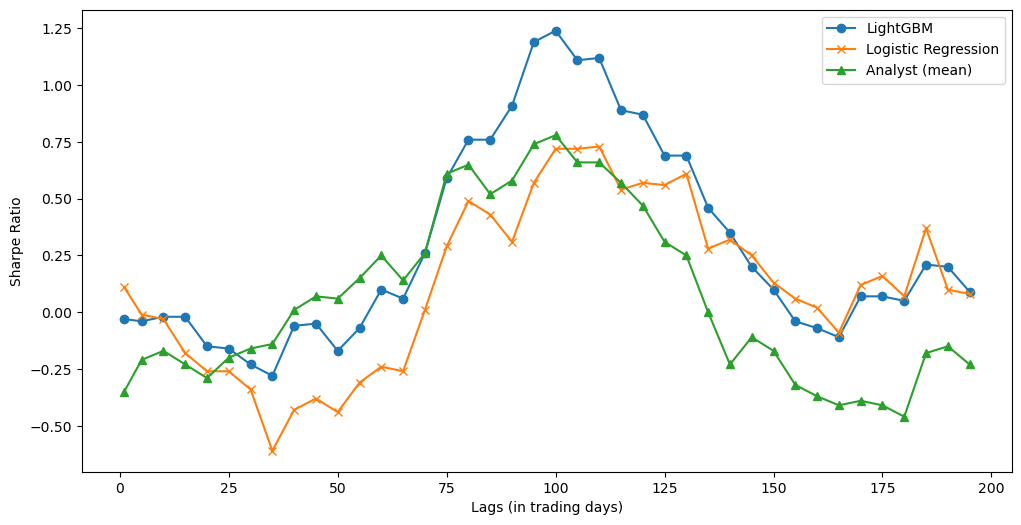

In [24]:
df_lags = pd.DataFrame({'lags':lags_list, 'lgbm_signal':lgbm_signal, 
                        'lr_signal':lr_signal,'analyst_signal':analyst_signal,
                        })

plt.figure(figsize=(12, 6))
plt.plot(df_lags["lags"], df_lags["lgbm_signal"], marker='o', label='LightGBM')
plt.plot(df_lags["lags"], df_lags["lr_signal"], marker='x', label='Logistic Regression')
plt.plot(df_lags["lags"], df_lags["analyst_signal"], marker='^', label='Analyst (mean)')
plt.xlabel('Lags (in trading days)')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.savefig(f'../figures/sharpe_ratio_lags.png', dpi=300, bbox_inches='tight',format='png')
plt.show()

### Plot Hedge Portfolio

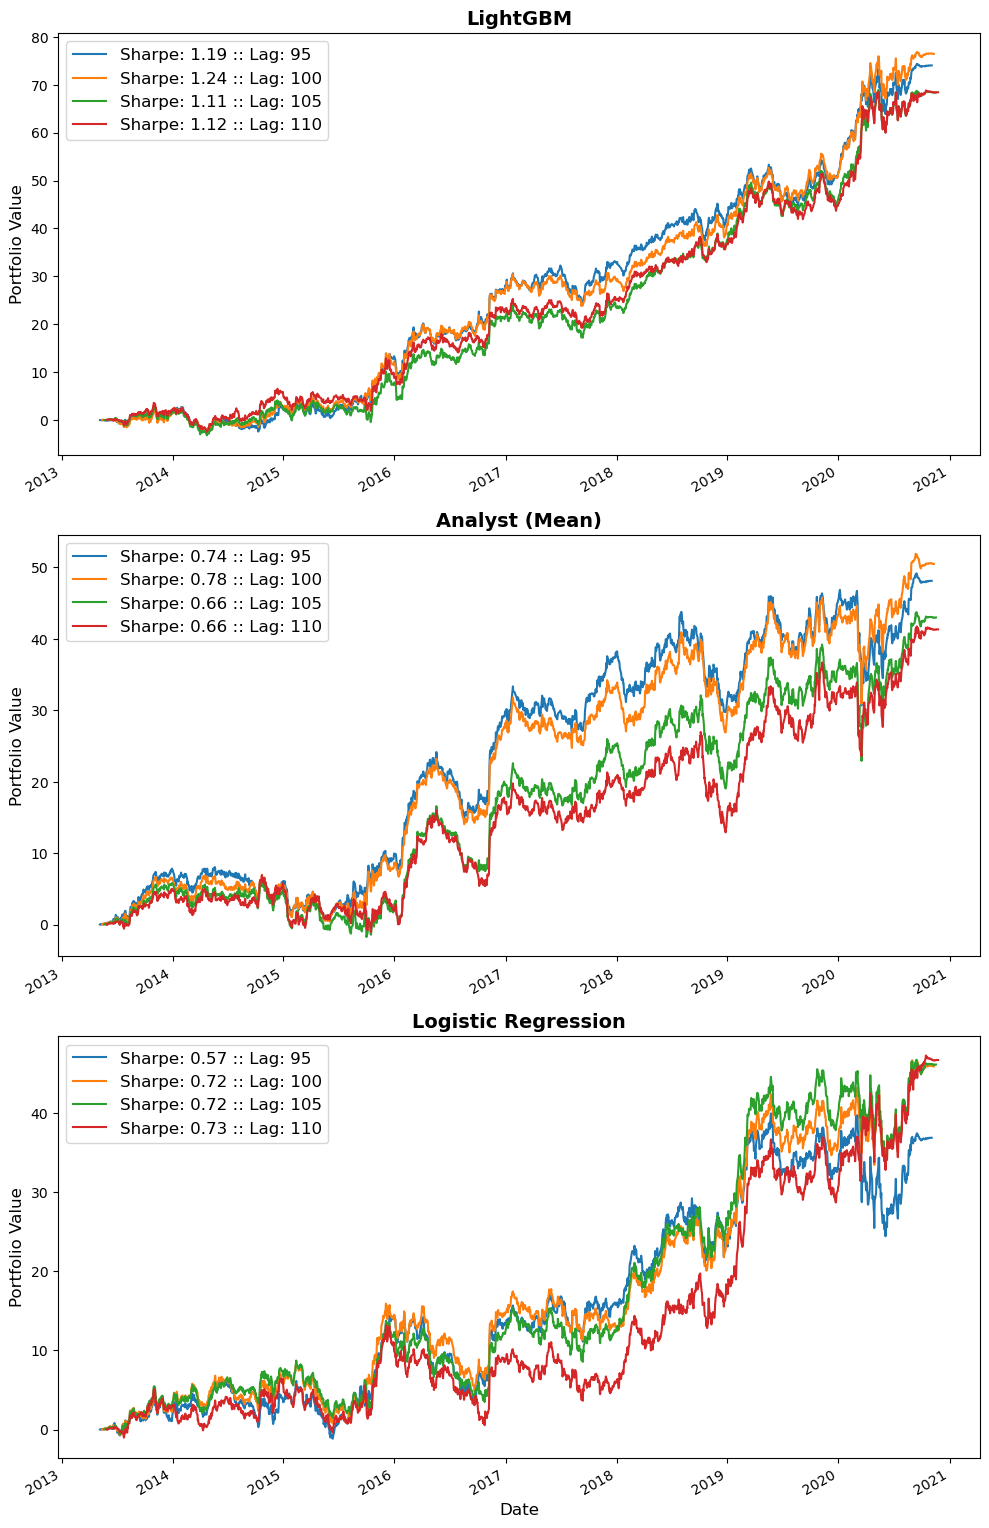

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

for i in range(3):
    weights = predictions_dfs3[i]

    name = ['LightGBM','Analyst (Mean)', 'Logistic Regression'][i]
    ax = axes[i]
    for lag in [95,100,105,110]:
        rets = (weights.shift(lag) * prices_df3.shift(-1)).sum(axis=1)
        rets = rets[(rets!=0)]

        sharpe = round(np.sqrt(252) 
                       * (rets.mean())/rets.std(), 2)
        rets.cumsum().plot(label = f'Sharpe: {sharpe} :: Lag: {lag}', ax=ax)
    ax.set_title(f"{name}", fontsize=14, weight='bold')
    ax.set_xlabel('Date', fontsize=12) if i not in [0,1] else ax.set_xlabel('')
    ax.set_ylabel('Portfolio Value', fontsize=12)
    ax.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=1)
plt.savefig(f'../figures/portfolio_performance.png', dpi=300, bbox_inches='tight',format='png')
plt.show()